### Divine Talk Recommendation
#### Feature Engineering of Astrologer vector
For the purpose of training the first model, we will use data from active as well as inactive astrologers

In [1]:
import pandas as pd
import mysql.connector as sql
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%%capture --no-display
#magic command to avoid printing warnings
#connecting to database
db_connection = sql.connect(host='localhost', database='divinetalk', user='root', password='root')
astr_df = pd.read_sql('SELECT id, name, status, language, rating,\
    experiance, total_payment FROM `astrologers`', con=db_connection)
astr_df.rename(columns = {'id':'astrologer_id', 'experiance':'experience'}, inplace = True)
#what is created, updated, deleted at, call, chat_prev_status

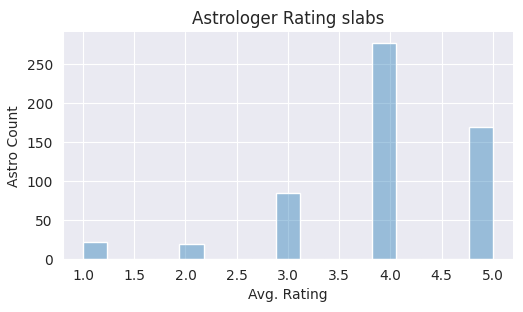

508 / 1079 unrated astrologers
199 / 684 unrated active astrologers
29 % unrated active astrologers


In [3]:
with sns.axes_style("darkgrid"):
    ax = sns.displot(astr_df['rating'], height=3, aspect=16/9, alpha=0.4)
ax.set(ylabel='Astro Count', xlabel='Avg. Rating')
plt.title('Astrologer Rating slabs') #from table astrologers
plt.show()
#why only integer rating of astrologer?
print(astr_df['rating'].isna().sum(), "/", astr_df.shape[0], "unrated astrologers")
#active unrated astrologers
print(astr_df.loc[astr_df['status']==1, 'rating'].isna().sum(), "/",\
    astr_df.loc[astr_df['status']==1].shape[0], "unrated active astrologers")
print(int((astr_df.loc[astr_df['status']==1, 'rating'].isna().sum()/\
    astr_df.loc[astr_df['status']==1].shape[0])*100), "% unrated active astrologers")

In [4]:
%%capture --no-display
df = pd.read_sql('SELECT * FROM `reviews_ratings`', con=db_connection)
df.loc[df['astrologer_id']>2000].astrologer_id.unique()
# df1 = pd.read_sql('SELECT id, user_id, astrologer_id FROM `orders`', con=db_connection)
# #skip these ratings?
# #can match by using order_id with table orders
# for idx in df.index[df['astrologer_id']>2000].tolist():
#     df.loc[idx, 'astrologer_id'] =\
#         df1.loc[df1.index[df1['id']==df.loc[idx, 'order_id']].tolist()[0], 'astrologer_id']
# del df1

array([10000000, 10000012, 20000002, 20000011, 20000012, 20000008,
       20000004, 20000003, 20000010, 20000006, 20000013, 20000015,
       20000014, 10000025, 20000017, 10000014, 10000007, 10000024,
       10000030, 10000031])

```
100000xx -> Healer
200000xx -> Advisor
```
Healers & Advisors, will be covered in further iterations of model due to data crunch in these cateogy of experts

In [5]:
%%capture --no-display
df = df[['astrologer_id','rating']].groupby('astrologer_id').agg(['count','mean']).reset_index()
astr_df = pd.merge(astr_df, df, how='left', on = 'astrologer_id')
astr_df.rename(columns = {('rating', 'count'):'rating_cnt', ('rating', 'mean'):'rating_avg'}, inplace = True)
del df

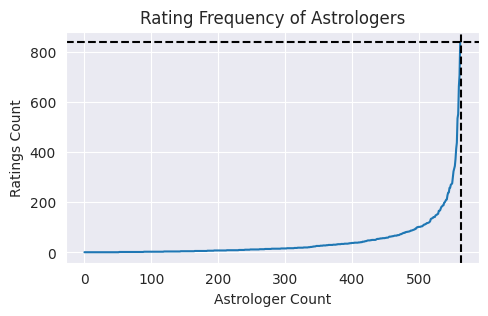

In [6]:
plt.figure(figsize=(16/3, 3))
with sns.axes_style("darkgrid"):
    ax = sns.lineplot(astr_df['rating_cnt'].sort_values().reset_index()['rating_cnt'])
ax.set(ylabel='Ratings Count', xlabel='Astrologer Count')
plt.title('Rating Frequency of Astrologers')
# ymax = np.nanmax(astr_df['rating_cnt'])
# xmax = astr_df['rating_cnt'].count()
# plt.annotate('local max', xy=(xmax, ymax), xytext=(xmax, ymax + 5), arrowprops=dict(facecolor='black'),)
plt.axvline(astr_df['rating_cnt'].count(), color='k', linestyle='--')
plt.axhline(np.nanmax(astr_df['rating_cnt']), color='k', linestyle='--')
plt.show()

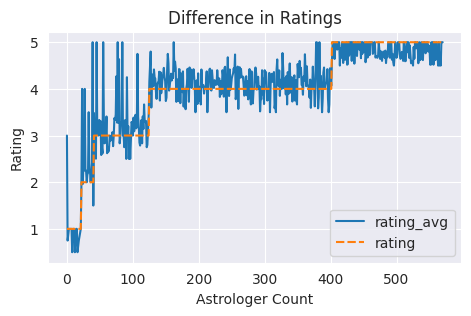

In [7]:
plt.figure(figsize=(16/3, 3))
with sns.axes_style("darkgrid"):
    ax = sns.lineplot(astr_df.sort_values(by=['rating']).reset_index()[['rating_avg', 'rating']])
ax.set(ylabel='Rating', xlabel='Astrologer Count')
#plt.legend(labels=['Rating Astro Table', 'Avg. Rating Orders Table'])
plt.title('Difference in Ratings')
plt.show()
astr_df.drop(['rating'], axis=1, inplace=True)

In [8]:
lang_set = set()
#lang = []
for idx in range(astr_df.shape[0]):
    if not (astr_df.loc[idx, 'language']):
        #lang.append(None)
        continue
    #lang.append(np.array(list(astr_df.loc[idx, 'language'][1:-1].replace("\"","").split(","))))
    lang_set.update(list(astr_df.loc[idx, 'language'][1:-1].replace("\"","").split(",")))
#lang = np.array(lang)
list(lang_set)

['Malayalam',
 'Punjabi',
 'Odiya',
 'Rajasthani',
 'Tamil',
 'Kashmiri',
 'Sindhi',
 'Hindi',
 'English',
 'Gujrati',
 'Telegu',
 'Bengali',
 'kannada',
 'Marathi']

#### Languages
Currently a list of **14** languages are preferred by astrologers. Each of these languages will be added to the feature space of the astrologer matrix. This will work as one-hot encoding for the categorical variable of astrologer language

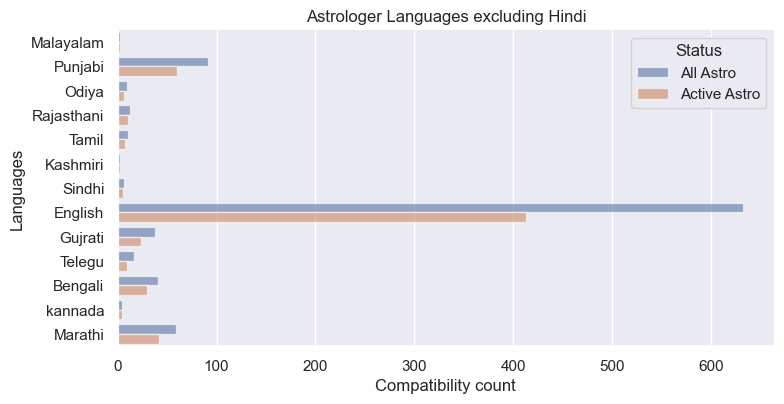

In [9]:
sns.set_theme()
astr_df[list(lang_set)]=0
for idx in range(astr_df.shape[0]):
    if not (astr_df.loc[idx, 'language']):
        continue
    astr_df.loc[idx, list(astr_df.loc[idx, 'language'][1:-1].replace("\"","").split(","))]=1

df = pd.DataFrame(
    {
        "All Astro": list(astr_df[list(lang_set)].sum().values),
        "Active Astro": list(astr_df.loc[astr_df['status']==1, list(lang_set)].sum().values)
    },
    index=list(lang_set)
).reset_index()
df.rename(columns = {'index':'Languages'}, inplace = True)
#df1 = pd.melt(df, id_vars="Languages", var_name="Status", value_name="Compatibility count")

#plt.figure(figsize=(14,3))
# sns.catplot(y='Languages', x='Compatibility count', hue='Status', data=df1,\
#     kind='bar', height=4, aspect=1, legend=False)
df1 = pd.melt(df.drop(df.loc[df['Languages']=="Hindi"].index), id_vars="Languages", var_name="Status", value_name="Compatibility count")
sns.catplot(y='Languages', x='Compatibility count', hue='Status', data=df1,\
    kind='bar', height=4, aspect=2, legend=False, alpha=0.6)

plt.title('Astrologer Languages excluding Hindi') #from table astrologers
plt.legend(loc='upper right', title='Status')
plt.show()
astr_df.drop(['language'], axis=1, inplace=True)
del df, df1, lang_set

#### Categories & Specialities
Currently a list of **20** category astrologers are offered within the app which broadly have **4** specialities. Each of these categories will be added to the feature space of the astrologer matrix. This will work as one-hot encoding for the categorical variable of astrologer category, speciality

In [10]:
%%capture --no-display
#astro_cat_pivots, categories data tables
astro_cat = pd.read_sql('SELECT * FROM `astro_cat_pivots`', con=db_connection)
cats = pd.read_sql('SELECT id, name FROM `categories`', con=db_connection)
astro_spec = pd.read_sql('SELECT * FROM `astro_specialitie_pivots`', con=db_connection)
spec = pd.read_sql('SELECT id, name FROM `astrologer_specialities`', con=db_connection)

In [11]:
list(cats['name'])

['Numerology',
 'Vedic',
 'Vastu',
 'Tarot Card Reading',
 'Healer',
 'Lal Kitab',
 'Face Reader',
 'Palm Reader',
 'Psychic',
 'Prashna',
 'KP',
 'Nadi',
 'DICE READER',
 'REIKI GRAND MASTER',
 'Match Making',
 'Name Correction',
 'Talking Therapy',
 'Pendulum Dowsing',
 'Spell Casting',
 'Reiki Healing']

In [12]:
list(spec['name'])

['Love', 'Marriage', 'Career', 'Health']

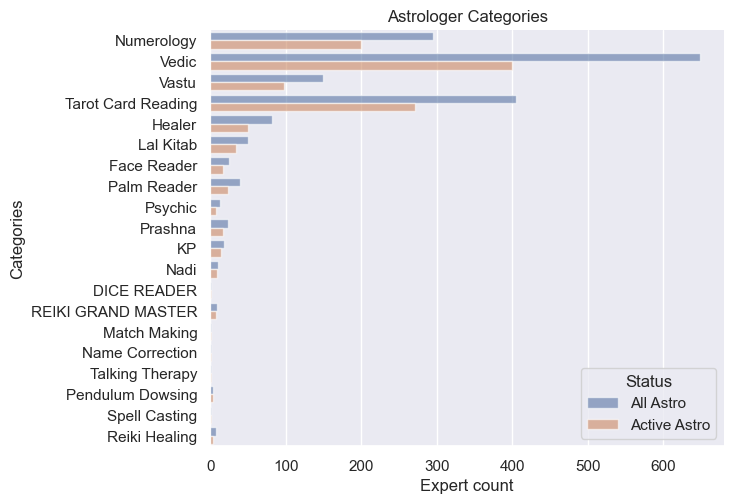

In [13]:
sns.set_theme()
astr_df[list(cats['name'])]=0
for idx in range(astro_cat.shape[0]):
    astr_df.loc[astro_cat.loc[idx, 'astrologer_id'],\
        cats.loc[cats[cats['id']==astro_cat.loc[idx, 'category_id']].index, 'name']]=1

df = pd.DataFrame(
    {
        "All Astro": list(astr_df[list(cats['name'])].sum().values),
        "Active Astro": list(astr_df.loc[astr_df['status']==1, list(cats['name'])].sum().values)
    },
    index=list(cats['name'])
).reset_index()
df.rename(columns = {'index':'Categories'}, inplace = True)

df1 = pd.melt(df, id_vars="Categories", var_name="Status", value_name="Expert count")
sns.catplot(y='Categories', x='Expert count', hue='Status', data=df1,\
    kind='bar', height=5, aspect=3/2, legend=False, alpha=0.6)

plt.title('Astrologer Categories')
plt.legend(loc='lower right', title='Status')
plt.show()
del astro_cat, cats, df, df1

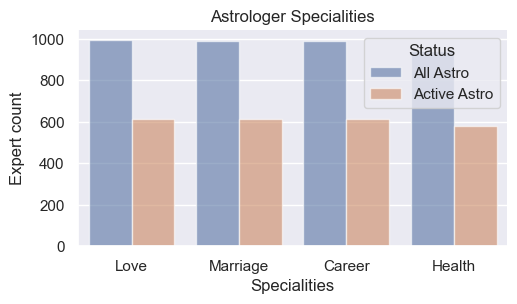

In [14]:
sns.set_theme()
astr_df[list(spec['name'])]=0
for idx in range(astro_spec.shape[0]):
    astr_df.loc[astro_spec.loc[idx, 'astrologer_id'],\
        spec.loc[spec[spec['id']==astro_spec.loc[idx, 'astrologer_speciality_id']].index, 'name']]=1

df = pd.DataFrame(
    {
        "All Astro": list(astr_df[list(spec['name'])].sum().values),
        "Active Astro": list(astr_df.loc[astr_df['status']==1, list(spec['name'])].sum().values)
    },
    index=list(spec['name'])
).reset_index()
df.rename(columns = {'index':'Specialities'}, inplace = True)

df1 = pd.melt(df, id_vars="Specialities", var_name="Status", value_name="Expert count")
sns.catplot(x='Specialities', y='Expert count', hue='Status', data=df1,\
    kind='bar', height=3, aspect=16/9, legend=False, alpha=0.6)

plt.title('Astrologer Specialities')
plt.legend(loc='upper right', title='Status')
plt.show()
astr_df.drop(list(spec['name']), axis=1, inplace=True)
del astro_spec, spec, df, df1

Since, pretty much all astrologers specialize in all the currently available specialities, having the specialities in our feature space won't help us have better recommendations. Hence, we drop this from the feature space

#### Astrologer Followers

In [15]:
%%capture --no-display
flwrs = pd.read_sql('SELECT * FROM `astrologer_followers`', con=db_connection)

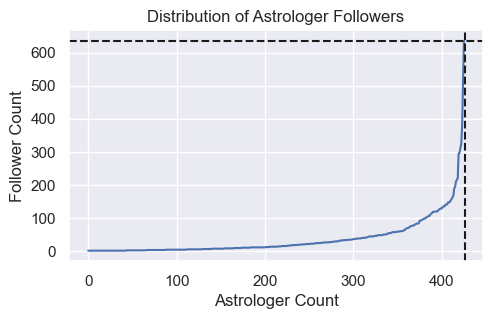

426 / 1079 astrollogers have non-zero followers
44 astrologers have follower count greater than 100


In [16]:
astr_df['Followers']=0
for idx in range(flwrs.shape[0]):
    astr_df.loc[astr_df[astr_df['astrologer_id']==flwrs.loc[idx, 'astrologer_id']].index, 'Followers']+=1
sns.set_theme()
plt.figure(figsize=(16/3, 3))
ax = sns.lineplot(astr_df.loc[astr_df['Followers']>0, 'Followers'].sort_values().reset_index()['Followers'])
ax.set(ylabel='Follower Count', xlabel='Astrologer Count')
plt.title('Distribution of Astrologer Followers')
plt.axvline(astr_df.loc[astr_df['Followers']>0, 'astrologer_id'].count(), color='k', linestyle='--')
plt.axhline(np.nanmax(astr_df['Followers']), color='k', linestyle='--')
plt.show()
# X/Y astrollogers have non-zero followers
# Z astrologers have followers > 100
astr_df.drop(astr_df.tail(1).index,inplace=True)
print(astr_df.loc[astr_df['Followers']>0, 'astrologer_id'].count(), "/",\
    astr_df.shape[0], "astrollogers have non-zero followers")
print(astr_df.loc[astr_df['Followers']>100, 'astrologer_id'].count(), "astrologers have follower count greater than 100")
del flwrs

In [29]:
%%capture --no-display
checkin_log = pd.read_sql('SELECT astrologer_id, type,\
    hours FROM `astrologer_checkin_log` WHERE role_id=7', con=db_connection)
checkin_log = checkin_log[checkin_log['hours']>pd.Timedelta(0)].reset_index() #eliminate 0 time entries

In [32]:
#Skip cell for time
astr_df[['chat_time', 'audio_time', 'live_time']] = pd.Timedelta(0)
for idx in range(checkin_log.shape[0]):
    astro_table_idx = astr_df[astr_df['astrologer_id']==checkin_log.loc[idx, 'astrologer_id']].index
    type_checkin = checkin_log.loc[idx, 'type']
    if type_checkin==1:
        astr_df.loc[astro_table_idx, 'chat_time']+=checkin_log.loc[idx, 'hours']
    elif type_checkin==2:
        astr_df.loc[astro_table_idx, 'audio_time']+=checkin_log.loc[idx, 'hours']
    elif type_checkin==3:
        astr_df.loc[astro_table_idx, 'live_time']+=checkin_log.loc[idx, 'hours']

In [3]:
#del checkin_log
#astr_df.to_csv('astr_df.csv')
astr_df = pd.read_csv('astr_df.csv', index_col=0)
for param in ['chat_time', 'audio_time', 'live_time']:
    astr_df[param] = pd.to_timedelta(astr_df[param])

In [5]:
astr_df

,astrologer_id,name,status,experience,total_payment,rating_cnt,rating_avg,Malayalam,Punjabi,Odiya,...,Match Making,Name Correction,Talking Therapy,Pendulum Dowsing,Spell Casting,Reiki Healing,Followers,chat_time,audio_time,live_time
0,1.0,Aachrya Gautam,0.0,22.0,0.00,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0 days 00:00:00,0 days 20:37:54,0 days 00:00:00
1,2.0,Aashish Vig,1.0,3.0,437.34,78.0,3.737179,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,19,0 days 21:35:50,31 days 01:09:44,0 days 13:23:22
2,3.0,Aashu Pathak,0.0,3.0,0.00,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00
3,4.0,Abhay Shukla,0.0,10.0,220.22,3.0,5.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,3 days 23:28:57,8 days 19:10:02,0 days 00:00:29
4,5.0,Abhishek Dubey,0.0,3.0,0.00,1.0,5.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5,1 days 22:07:30,28 days 20:44:20,0 days 01:43:51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1074,1075.0,Jaskirat Bhatia,0.0,3.0,0.00,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00
1075,1076.0,Geetanjali Gupta,1.0,3.0,0.00,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00
1076,1077.0,Preksha Gupta,0.0,3.0,0.00,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00
1077,1078.0,Astro Rakesh,0.0,8.0,0.00,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00
